In [ ]:
!pip install effdet -q

     |████████████████████████████████| 112kB 26.3MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
     |████████████████████████████████| 348kB 42.5MB/s 
     |████████████████████████████████| 112kB 53.2MB/s 
     |████████████████████████████████| 645kB 48.2MB/s 


In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
!bash install_colab.sh

--2021-06-11 11:27:27--  https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 361 [text/plain]
Saving to: ‘install_colab.sh’

install_colab.sh    100%[===================>]     361  --.-KB/s    in 0s      

2021-06-11 11:27:27 (17.4 MB/s) - ‘install_colab.sh’ saved [361/361]

  Cloning git://github.com/airctic/icevision.git to /tmp/pip-install-0fmv7gm7/icevision
  Running command git clone -q git://github.com/airctic/icevision.git /tmp/pip-install-0fmv7gm7/icevision
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 81kB 10.1MB/s 
     |████████████████████████████████| 81kB 10.0MB/s 
 

In [ ]:
import icevision
from icevision.all import *
from icevision.models.ross.efficientdet.dataloaders import process_train_record, build_infer_batch
from icevision.models.ross.efficientdet import convert_raw_predictions

INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:69
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:16


0B [00:00, ?B/s]

In [ ]:
from effdet import get_efficientdet_config, create_model_from_config, unwrap_bench, create_model, load_checkpoint
from effdet.bench import _post_process, _batch_detection
from effdet.config import set_config_readonly, set_config_writeable
from effdet.efficientdet import get_feature_info, BiFpn, BiFpnLayer, HeadNet, _init_weight, _init_weight_alt
from effdet.loss import DetectionLoss
from effdet.anchors import Anchors, AnchorLabeler
from fastai.vision.all import *
from fastai.vision.learner import create_head

In [ ]:
import timm
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preparing data

In [ ]:
path = Path('/content/drive/My Drive/colab_notebooks/COVID')
path_img = path/'train256'
train_df = pd.read_csv(path/'COVID_train_df.csv')
dcm_df = pd.read_csv(path/'COVID_dcm_metadata.csv')
label_df = pd.read_csv(path/'bounding_boxes256.csv')

In [ ]:
label_df['label_only'] = label_df['label'].apply(lambda x: x.split(' ')[0])

In [ ]:
label_df['new_label'] = None
for i, row in label_df.iterrows():
    lab = row['label'].split(' ')
    new = []
    for j in range(len(lab)):
        if (lab[j] == 'opacity') or (lab[j] == 'none'):
           new.append(lab[j+2:j+6])

    label_df.loc[i, 'new_label'] = new

In [ ]:
train_df['classi_label'] = train_df.iloc[:, -4:].idxmax(axis=1)
train_df['image_id'] = train_df['id'].apply(lambda x: f'{x.split("_")[0]}.jpg')
classi_label_mapper = train_df.loc[:, ['image_id', 'classi_label']].set_index('image_id').to_dict()

In [ ]:
label_df['classi_label'] = label_df['image_id'].map(classi_label_mapper['classi_label'])

In [ ]:
print(label_df['classi_label'].value_counts(),'\n\n', train_df['classi_label'].value_counts(), sep='')

Typical Appearance          3007
Negative for Pneumonia      1736
Indeterminate Appearance    1108
Atypical Appearance          483
Name: classi_label, dtype: int64

Typical Appearance          3007
Negative for Pneumonia      1736
Indeterminate Appearance    1108
Atypical Appearance          483
Name: classi_label, dtype: int64


# Parser and Dataloader

In [ ]:
# Here ObjectDetectionRecord from icevision and added ClassificationLabelsRecordComponent
def ObjectDetectionClassiRecord():
    return BaseRecord(
        (
            FilepathRecordComponent(),
            InstancesLabelsRecordComponent(),
            BBoxesRecordComponent(),
            ClassificationLabelsRecordComponent(),
        )
    )

In [ ]:
template_record = ObjectDetectionClassiRecord()

In [ ]:
#custom parser from icevision - added classification class map and classification labels
class CustomParser(Parser):
    def __init__(self, template_record, img_dir, label_df):
        super().__init__(template_record=template_record)

        self.img_dir = img_dir
        self.df = label_df
        self.class_map = ClassMap(list(self.df['label_only'].unique()))
        self.classi_class_map = ClassMap(list(self.df['classi_label'].unique()), background=None)

    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o

    def __len__(self) -> int:
        return len(self.df)

    def record_id(self, o) -> Hashable:
        return o.image_id

    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(f'{self.img_dir}/{o.image_id}')
            record.set_img_size(ImgSize(width=256, height=256))
            record.detection.set_class_map(self.class_map)
            record.classification.set_class_map(self.classi_class_map)
            record.classification.set_labels([o.classi_label])

        record.detection.add_bboxes([BBox.from_xyxy(float(bb[0]), float(bb[1]), float(bb[2]), float(bb[3])) for bb in o.new_label])
        record.detection.add_labels([o.label_only for _ in o.new_label])

In [ ]:
parser = CustomParser(template_record, path_img, label_df)

In [ ]:
train_records, valid_records = parser.parse(autofix=True)

  0%|          | 0/6334 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:136


  0%|          | 0/5067 [00:00<?, ?it/s]

  0%|          | 0/1267 [00:00<?, ?it/s]

In [ ]:
parser.class_map

<ClassMap: {'background': 0, 'opacity': 1, 'none': 2}>

In [ ]:
parser.classi_class_map

<ClassMap: {'Typical Appearance': 0, 'Negative for Pneumonia': 1, 'Atypical Appearance': 2, 'Indeterminate Appearance': 3}>

In [ ]:
#TODO: to add only specific augmentations 
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=256), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(256), tfms.A.Normalize()])

In [ ]:
# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

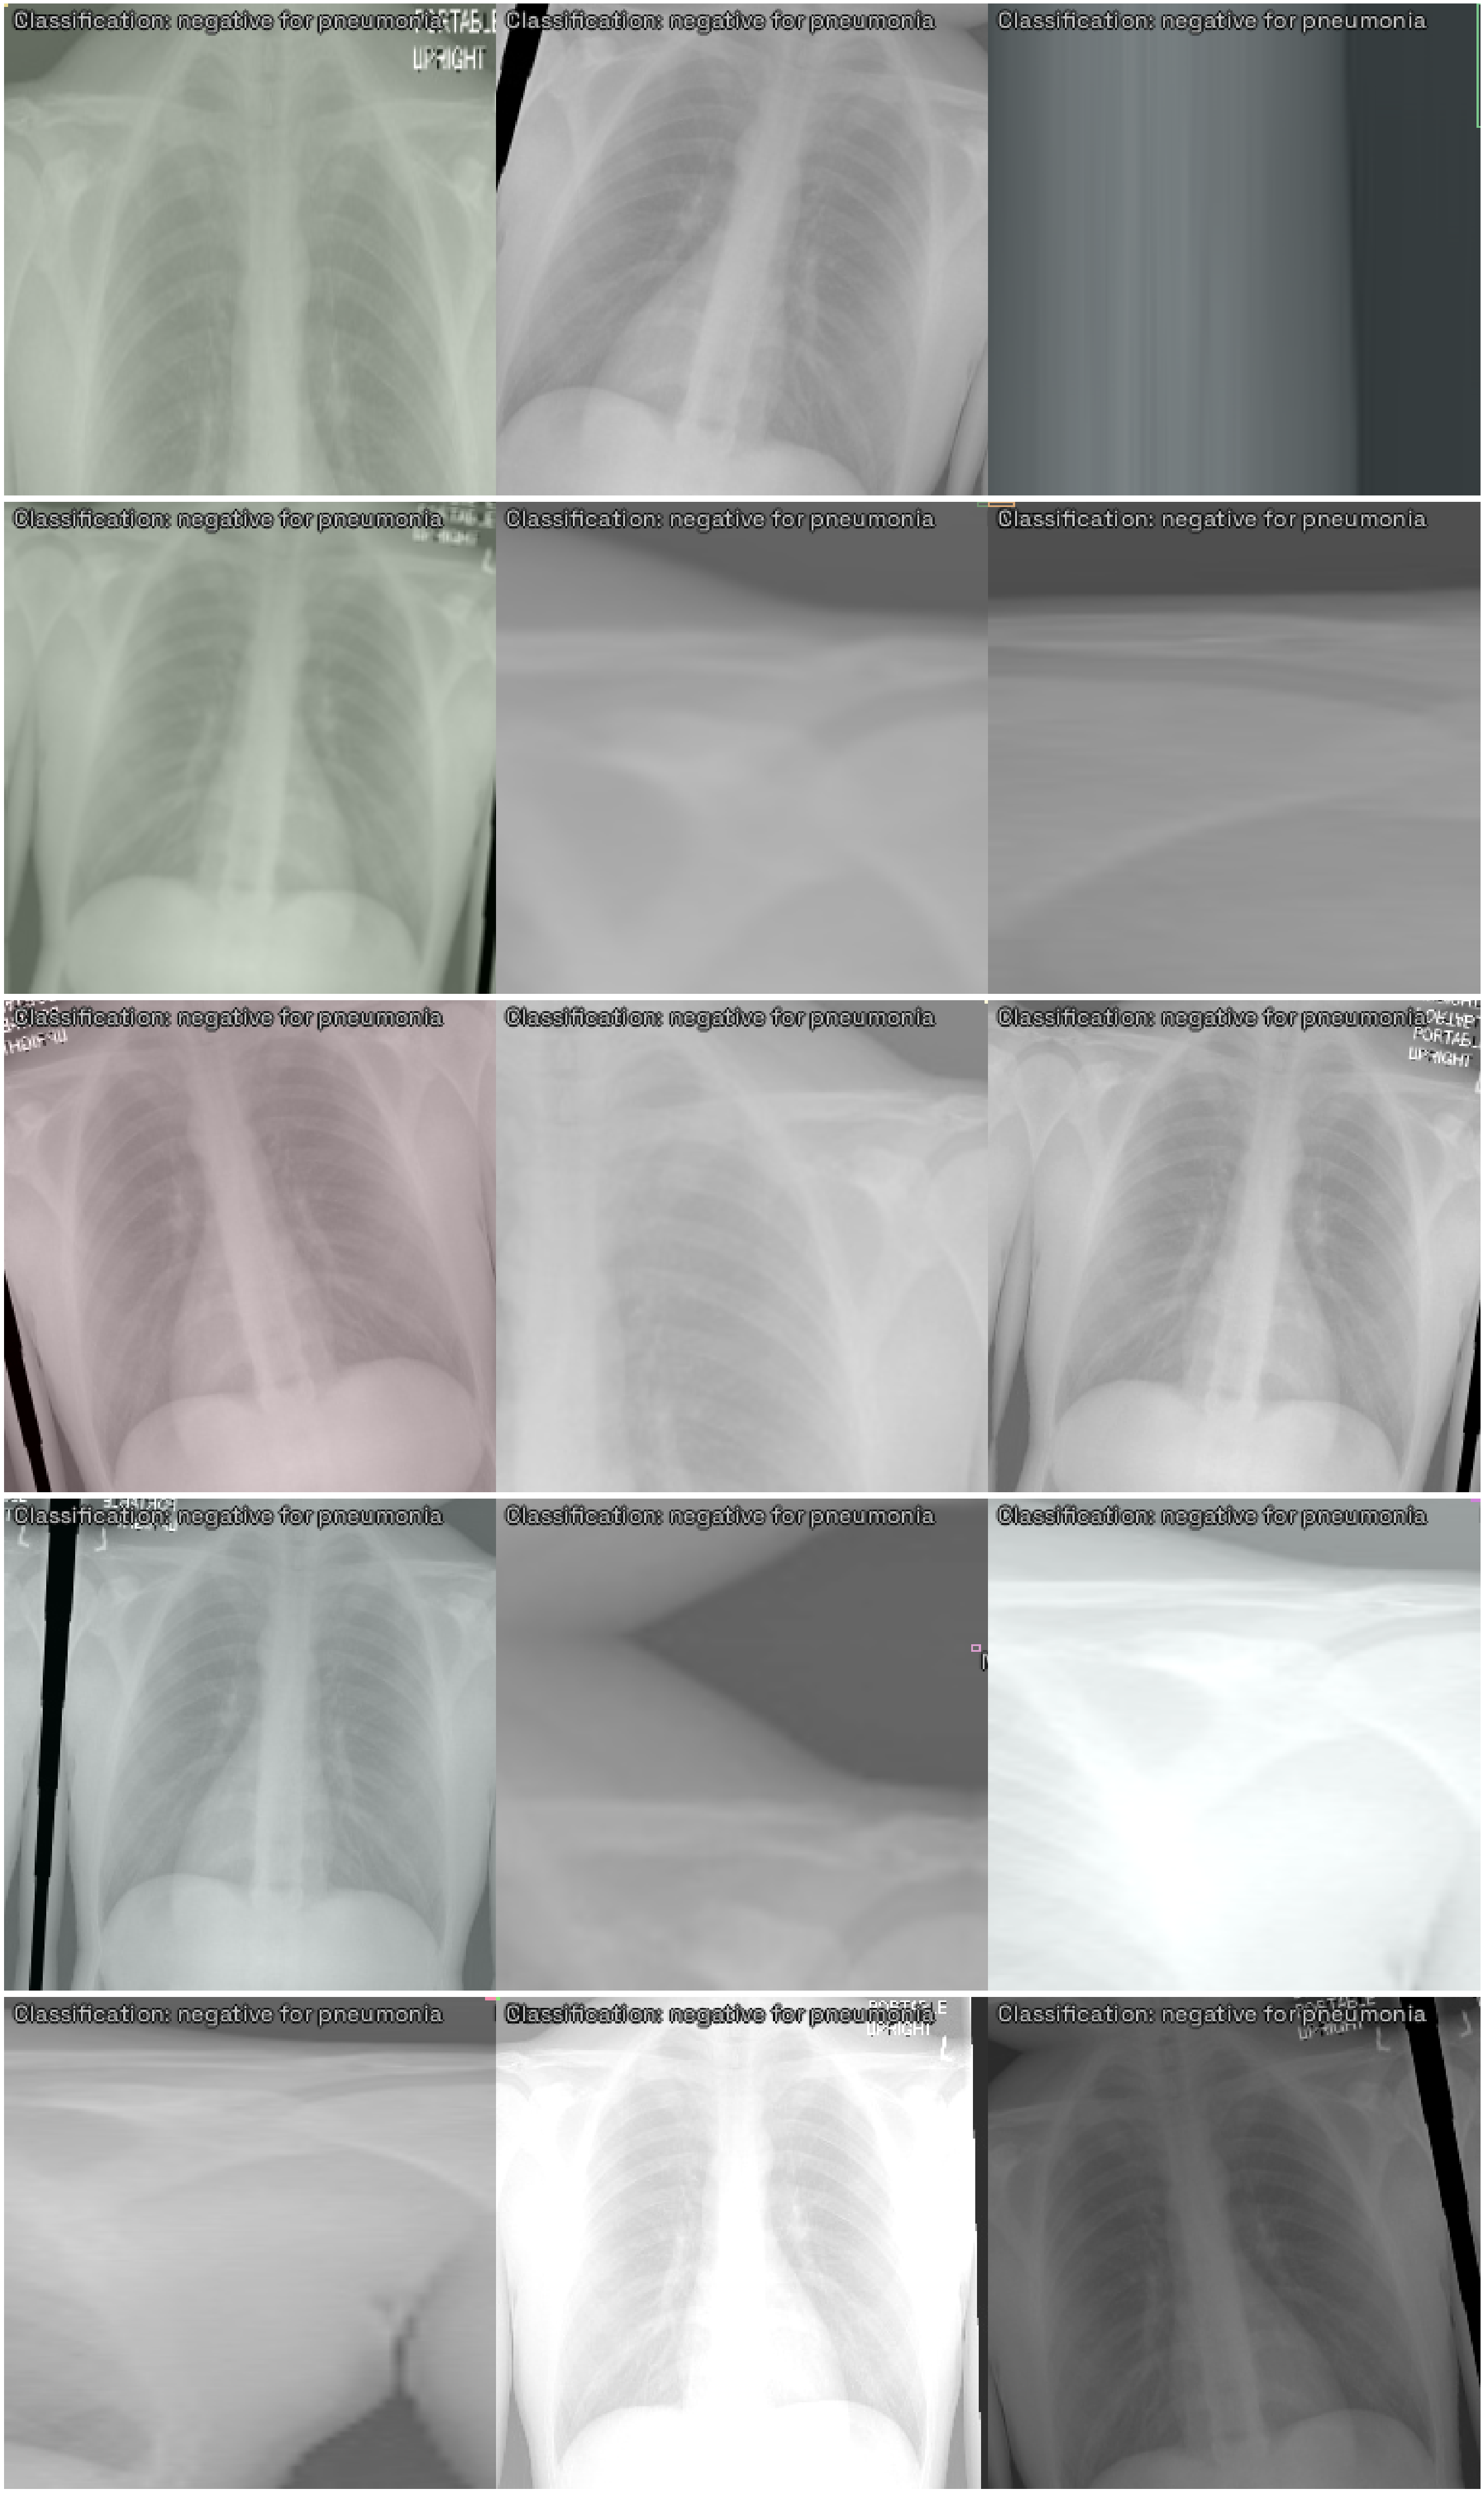

In [ ]:
#Successfully shows classification!
samples = [train_ds[1] for _ in range(15)]
show_samples(samples, ncols=3)

In [ ]:
# the fuction below is extension of build_train_batch from Icevision. this is to add batch_classi targets["classi"] which is  targets for classification
def build_train_batch_m(records):

    batch_images, batch_bboxes, batch_classes = zip(
        *(process_train_record(record) for record in records)
    )
    batch_classi = [record.classification.label_ids for record in records] #INSERTED CODE

    # convert to tensors
    batch_images = torch.stack(batch_images)
    batch_bboxes = [tensor(bboxes, dtype=torch.float32) for bboxes in batch_bboxes]
    batch_classes = [tensor(classes, dtype=torch.float32) for classes in batch_classes] 
    batch_classi = [tensor(classes, dtype=torch.float32) for classes in batch_classi] #INSERTED CODE

    # convert to EffDet interface
    targets = dict(bbox=batch_bboxes, cls=batch_classes, classi=batch_classi)

    return (batch_images, targets), records

In [ ]:
# the fuction below make use of build_train_batch_m to build valid_ds
def build_valid_batch_m(records):

    (batch_images, targets), records = build_train_batch_m(records)

    # convert to EffDet interface, when not training, dummy size and scale is required
    targets = dict(img_size=None, img_scale=None, **targets)

    return (batch_images, targets), records

In [ ]:
def train_dl_m(dataset, batch_tfms=None, **dataloader_kwargs) -> DataLoader:
    return transform_dl(
        dataset=dataset,
        build_batch=build_train_batch_m,
        batch_tfms=batch_tfms,
        **dataloader_kwargs
    )

In [ ]:
def valid_dl_m(dataset, batch_tfms=None, **dataloader_kwargs) -> DataLoader:

    return transform_dl(
        dataset=dataset,
        build_batch=build_valid_batch_m,
        batch_tfms=batch_tfms,
        **dataloader_kwargs
    )


In [ ]:
train_dl = train_dl_m(train_ds, batch_size=8, num_workers=2, shuffle=True)
valid_dl = valid_dl_m(valid_ds, batch_size=8, num_workers=2, shuffle=False)

# Preparing EffDetBench

In [ ]:
#modeified effdet's EfficientDet to calculate classification output from backbone's output
class EfficientDetClassi(nn.Module):
    def __init__(self, config, pretrained_backbone=True, classi_class=None, alternate_init=False):
        super(EfficientDetClassi, self).__init__()
        self.config = config
        set_config_readonly(self.config)
        self.backbone = timm.create_model(
            config.backbone_name, features_only=True,
            out_indices=self.config.backbone_indices or (2, 3, 4),
            pretrained=pretrained_backbone, **config.backbone_args)
        feature_info = get_feature_info(self.backbone)
        self.fpn = BiFpn(self.config, feature_info)
        self.class_net = HeadNet(self.config, num_outputs=self.config.num_classes)
        self.box_net = HeadNet(self.config, num_outputs=4)

        #INSERTED CODE STARTS
        backbone_features = num_features_model(nn.Sequential(*self.backbone.children()))
        self.classifier = create_head(backbone_features, classi_class) #fastai's create_head
        #INSERTED CODE ENDS
        '''
        self.classifier = nn.Sequential(
                                        nn.AdaptiveMaxPool2d(output_size=1),
                                        nn.Flatten(),
                                        nn.BatchNorm1d(backbone_features),
                                        nn.Dropout(p=0.25, inplace=False),
                                        nn.Linear(backbone_features, 512),
                                        nn.ReLU(inplace=True),
                                        nn.BatchNorm1d(512),
                                        nn.Dropout(p=0.25, inplace=False),
                                        nn.Linear(512, classi_class), 
        )
  
        '''
        for n, m in self.named_modules():
            if 'backbone' not in n:
                if alternate_init:
                    _init_weight_alt(m, n)
                else:
                    _init_weight(m, n)

    @torch.jit.ignore()
    def reset_head(self, num_classes=None, aspect_ratios=None, num_scales=None, alternate_init=False):
        reset_class_head = False
        reset_box_head = False
        set_config_writeable(self.config)
        if num_classes is not None:
            reset_class_head = True
            self.config.num_classes = num_classes
        if aspect_ratios is not None:
            reset_box_head = True
            self.config.aspect_ratios = aspect_ratios
        if num_scales is not None:
            reset_box_head = True
            self.config.num_scales = num_scales
        set_config_readonly(self.config)

        if reset_class_head:
            self.class_net = HeadNet(self.config, num_outputs=self.config.num_classes)
            for n, m in self.class_net.named_modules(prefix='class_net'):
                if alternate_init:
                    _init_weight_alt(m, n)
                else:
                    _init_weight(m, n)

        if reset_box_head:
            self.box_net = HeadNet(self.config, num_outputs=4)
            for n, m in self.box_net.named_modules(prefix='box_net'):
                if alternate_init:
                    _init_weight_alt(m, n)
                else:
                    _init_weight(m, n)

    @torch.jit.ignore()
    def toggle_head_bn_level_first(self):
        """ Toggle the head batchnorm layers between being access with feature_level first vs repeat
        """
        self.class_net.toggle_bn_level_first()
        self.box_net.toggle_bn_level_first()

    def forward(self, x):
        x_b = self.backbone(x)
        x = self.fpn(x_b)
        x_class = self.class_net(x)
        x_box = self.box_net(x)
        x_classi = self.classifier(x_b[2]) #INSERTED CODE
        return x_class, x_box, x_classi #returns x_classi on top of original

In [ ]:
# Used DetBenchTrain  
class DetClassiBenchTrain(nn.Module):
    def __init__(self, model, create_labeler=True):
        super(DetClassiBenchTrain, self).__init__()
        self.model = model
        self.config = model.config
        self.num_levels = model.config.num_levels
        self.num_classes = model.config.num_classes
        self.anchors = Anchors.from_config(model.config)
        self.max_detection_points = model.config.max_detection_points
        self.max_det_per_image = model.config.max_det_per_image
        self.soft_nms = model.config.soft_nms
        self.anchor_labeler = None
        if create_labeler:
            self.anchor_labeler = AnchorLabeler(self.anchors, self.num_classes, match_threshold=0.5)
        self.loss_fn = DetectionLoss(model.config)
        self.classi_loss = CrossEntropyLossFlat() #INSERTED CODE - loss_fn for classification loss

    def forward(self, x, target: Dict[str, torch.Tensor]):
        class_out, box_out, classi_out = self.model(x) #OUTPUTS INCLUDE classiicaiton predictions
        if self.anchor_labeler is None:
            # target should contain pre-computed anchor labels if labeler not present in bench
            assert 'label_num_positives' in target
            cls_targets = [target[f'label_cls_{l}'] for l in range(self.num_levels)]
            box_targets = [target[f'label_bbox_{l}'] for l in range(self.num_levels)]
            num_positives = target['label_num_positives']
        else:
            cls_targets, box_targets, num_positives = self.anchor_labeler.batch_label_anchors(
                target['bbox'], target['cls'])

        classi_targets = torch.stack(target['classi']).squeeze().type(torch.LongTensor).to('cuda')
        loss, class_loss, box_loss = self.loss_fn(class_out, box_out, cls_targets, box_targets, num_positives)
        
        #INSERTED CODE STARTS
        classi_loss = self.classi_loss(classi_out, classi_targets)
        loss += classi_loss
        #INSERTED CODE ENDS

        output = {'loss': loss, 'class_loss': class_loss, 'box_loss': box_loss, 'classi_pred':classi_out, 'classi_loss':classi_loss} #ADDED "classi_loss"

        if not self.training:
            # if eval mode, output detections for evaluation
            class_out_pp, box_out_pp, indices, classes = _post_process(
                class_out, box_out, num_levels=self.num_levels, num_classes=self.num_classes,
                max_detection_points=self.max_detection_points)
            output['detections'] = _batch_detection(
                x.shape[0], class_out_pp, box_out_pp, self.anchors.boxes, indices, classes,
                target['img_scale'], target['img_size'],
                max_det_per_image=self.max_det_per_image, soft_nms=self.soft_nms)
            
        return output

In [ ]:
def create_model_m(model_name, bench_task='', num_classes=None, pretrained=False,
                 checkpoint_path='', checkpoint_ema=False, img_size=None, **kwargs):

    config = get_efficientdet_config(model_name)
    config.image_size = (img_size, img_size) if isinstance(img_size, int) else img_size

    return create_model_from_config_m(config, bench_task=bench_task, num_classes=num_classes, pretrained=pretrained,
                                      checkpoint_path=checkpoint_path, checkpoint_ema=checkpoint_ema, **kwargs)

In [ ]:
def create_model_from_config_m(
        config, bench_task='', num_classes=None, pretrained=False,
        checkpoint_path='', checkpoint_ema=False, **kwargs):

    pretrained_backbone = kwargs.pop('pretrained_backbone', True)
    if pretrained or checkpoint_path:
        pretrained_backbone = False  # no point in loading backbone weights

    # Config overrides, override some config values via kwargs.
    overrides = (
        'redundant_bias', 'label_smoothing', 'legacy_focal', 'jit_loss', 'soft_nms', 'max_det_per_image', 'image_size')
    for ov in overrides:
        value = kwargs.pop(ov, None)
        if value is not None:
            setattr(config, ov, value)

    labeler = kwargs.pop('bench_labeler', False)

    # create the base model
    model = EfficientDetClassi(config, pretrained_backbone=pretrained_backbone, **kwargs)
    
    # pretrained weights are always spec'd for original config, load them before we change the model
    if pretrained:
        load_pretrained(model, config.url)

    # reset model head if num_classes doesn't match configs
    if num_classes is not None and num_classes != config.num_classes:
        model.reset_head(num_classes=num_classes)

    # load an argument specified training checkpoint
    if checkpoint_path:
        load_checkpoint(model, checkpoint_path, use_ema=checkpoint_ema)

    # wrap model in task specific training/prediction bench if set
    if bench_task == 'train':
        model = DetClassiBenchTrain(model, create_labeler=True)
    elif bench_task == 'predict':
        model = DetClassiBenchPredict(model)
    return model

In [ ]:
def splitter(m):
    s = nn.Sequential(*m.model.children())
    return L(s[0], s[1:]).map(params)

In [ ]:
#lazy hack to report classification accuracy
class ClassiAccuracy(fastai.Callback):
    def after_epoch(self):
        self.learn.eval()
        acc, count = 0, 0
        for xv, yv in self.learn.dls.valid:
            out = self.learn.model(xv[0], xv[1])
            pred = torch.argmax(out["classi_pred"], 1).detach().to("cpu")
            targ = torch.stack(xv[1]["classi"]).squeeze().type(torch.LongTensor).detach().to('cpu')
            acc += (pred == targ).float().sum()
            count += xv[0].shape[0]
            
        print(f'Epoch {self.learn.epoch} : {acc/count*100:.3}')

# Create Model and fastai learner

In [ ]:
bench = create_model_m('tf_efficientdet_d3', 
                        'train',  
                        num_classes=len(parser.class_map)-1,
                        classi_class=len(parser.classi_class_map),
                        img_size=256)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_aa-84b4657e.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_aa-84b4657e.pth


In [ ]:
model_type = icevision.models.ross.efficientdet
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], 
                                  model=bench, 
                                  metrics=metrics,
                                  splitter = splitter,
                                  opt_func = fastai.ranger)

# Load model checkpoint

In [ ]:
PATH = path/'model/tf_d3.pth'

In [ ]:
bench.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Training

In [ ]:
model_fname = path/'model/tf_d3.2'

In [ ]:
savecbs = SaveModelCallback('valid_loss', fname=model_fname)

In [ ]:
#learn.freeze()
#learn.fit_flat_cos(10, 1e-3, cbs=[ClassiAccuracy(), savecbs])

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(50, 1e-3, cbs=[ClassiAccuracy(), savecbs])

epoch,train_loss,valid_loss,COCOMetric,time


epoch,train_loss,valid_loss,COCOMetric,time
0,1.725623,1.693868,0.080605,26:29
1,1.705787,1.743471,0.076129,07:46
2,1.609458,1.717685,0.077192,07:45
3,1.609989,1.723178,0.064782,07:45
4,1.633143,1.728129,0.074818,07:46
5,1.671056,1.657218,0.079416,07:46
6,1.682322,1.694872,0.075877,07:46
7,1.526803,1.772092,0.073410,07:47
8,1.704061,1.697254,0.080034,07:47
9,1.630523,1.751164,0.065722,07:51


Epoch 0 : 65.1
Better model found at epoch 0 with valid_loss value: 1.6938680410385132.
Epoch 1 : 65.4
Epoch 2 : 64.8
Epoch 3 : 65.2
Epoch 4 : 66.2
Epoch 5 : 66.6
Better model found at epoch 5 with valid_loss value: 1.6572182178497314.
Epoch 6 : 66.2
Epoch 7 : 62.6
Epoch 8 : 65.4
Epoch 9 : 65.1
Epoch 10 : 66.3
Epoch 11 : 61.6
Epoch 12 : 64.8
Epoch 13 : 63.4
Epoch 14 : 65.9
Epoch 15 : 65.9
Epoch 16 : 67.1
Epoch 17 : 65.2
Epoch 18 : 66.9
Epoch 19 : 65.4
Epoch 20 : 64.2
Epoch 21 : 64.6
Epoch 22 : 66.1
Epoch 23 : 66.9
Epoch 24 : 65.0
Epoch 25 : 62.4
Epoch 26 : 66.3
Epoch 27 : 67.3


# Inference

In [ ]:
class DetClassiBenchPredict(nn.Module):
    def __init__(self, model):
        super(DetClassiBenchPredict, self).__init__()
        self.model = model
        self.config = model.config  # FIXME remove this when we can use @property (torchscript limitation)
        self.num_levels = model.config.num_levels
        self.num_classes = model.config.num_classes
        self.anchors = Anchors.from_config(model.config)
        self.max_detection_points = model.config.max_detection_points
        self.max_det_per_image = model.config.max_det_per_image
        self.soft_nms = model.config.soft_nms

    def forward(self, x, img_info: Optional[Dict[str, torch.Tensor]] = None):
        class_out, box_out, classi_out = self.model(x)
        class_out, box_out, indices, classes = _post_process(
            class_out, box_out, num_levels=self.num_levels, num_classes=self.num_classes,
            max_detection_points=self.max_detection_points)
        if img_info is None:
            img_scale, img_size = None, None
        else:
            img_scale, img_size = img_info['img_scale'], img_info['img_size']
        return _batch_detection(x.shape[0], class_out, box_out, self.anchors.boxes, indices, classes,
                                img_scale, img_size, max_det_per_image=self.max_det_per_image, soft_nms=self.soft_nms
                                ), classi_out

In [ ]:
@torch.no_grad()
def _predict_batch_m(
    model,
    batch: Sequence[torch.Tensor],
    records: Sequence[BaseRecord],
    detection_threshold: float = 0.5,
    keep_images: bool = False,
    device: Optional[torch.device] = None,
) -> List[Prediction]:
    device = device or model_device(model)

    imgs, img_info = batch
    imgs = imgs.to(device)
    img_info = {k: v.to(device) for k, v in img_info.items()}

    bench = DetClassiBenchPredict(unwrap_bench(model))
    bench = bench.eval().to(device)

    raw_preds = bench(x=imgs, img_info=img_info)
    preds = convert_raw_predictions(
        batch=batch,
        raw_preds=raw_preds[0],
        records=records,
        detection_threshold=detection_threshold,
        keep_images=keep_images,
    )

    return preds, raw_preds[1]

def predict_m(
    model,
    dataset: Dataset,
    detection_threshold: float = 0.5,
    keep_images: bool = False,
    device: Optional[torch.device] = None,
) -> List[Prediction]:

    batch, records = build_infer_batch(dataset)
    return _predict_batch_m(
        model=model,
        batch=batch,
        records=records,
        detection_threshold=detection_threshold,
        keep_images=keep_images,
        device=device,
    )

In [ ]:
bench_predict = create_model_m( 'tf_efficientdet_d3', 
                                'predict',  
                                pretrained=False,
                                num_classes=len(parser.class_map)-1,
                                classi_class=len(parser.classi_class_map),
                                img_size=256)

In [ ]:
bench_predict.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
tst_img = path_img.ls()[:20]

In [ ]:
imgs = []
for p in tst_img:
    imgs.append(PILImage.create(p))

In [ ]:
infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=256), tfms.A.Normalize()])
infer_ds = Dataset.from_images(imgs, infer_tfms)

In [ ]:
model_type = icevision.models.ross.efficientdet
preds, classi = predict_m(bench_predict, infer_ds, keep_images=True)

In [ ]:
preds[0]

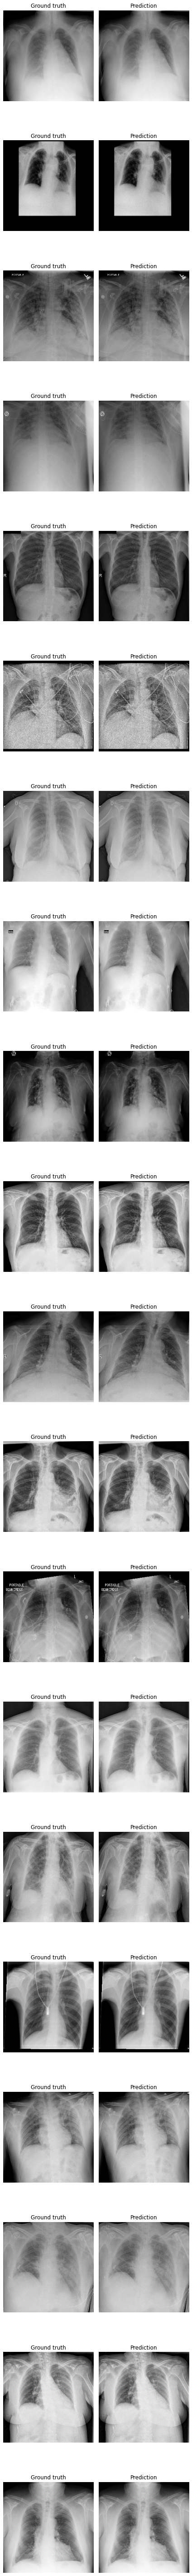

In [ ]:
show_preds(preds)

TODO:
1. try inference of DetClassi on Kaggle; get a baseline
3. try a classification model such as resnet/efficientnet compare classfication accuracy
4. try yolo compare mAP
5. explore augmentations 